In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import fly_analysis as fa
from fly_analysis.trajectory import detect_saccades
from scipy.ndimage import gaussian_filter

In [25]:
def create_saccade_heatmap(df, grid_size=50):
    """
    Create a heatmap of saccade locations in the circular arena.
    
    Args:
    df (pd.DataFrame): DataFrame containing fly trajectory data.
    grid_size (int): Number of grid cells along each dimension.
    
    Returns:
    np.array: 2D array representing the saccade heatmap.
    """
    # Define arena parameters
    arena_radius = 0.25  # 25cm radius
    x_range = y_range = [-arena_radius, arena_radius]
    
    # Create grid
    x_edges = np.linspace(x_range[0], x_range[1], grid_size + 1)
    y_edges = np.linspace(y_range[0], y_range[1], grid_size + 1)
    heatmap = np.zeros((grid_size, grid_size))
    
    # Process each trajectory
    for obj_id, group in df.groupby('obj_id'):

        if len(group) >= 300:
            if (-0.2 <= group.x.median() <= 0.2) & (-0.2 <= group.y.median() <= 0.2) & (0.1 <= group.z.median() <= 0.3):
                if (group.x.max()-group.x.min() > 0.1) & (group.y.max()-group.y.min() > 0.1) & (group.z.max()-group.z.min() > 0.1):
                    for section in fa.trajectory.extract_flying_sections(group, min_flight_duration=150): 
                        # Detect saccades
                        saccade_indices, _ = detect_saccades(section, height=1000)
                        
                        # Get saccade locations
                        saccade_locations = group.iloc[saccade_indices][['x', 'y']]

                        # Bin saccade locations
                        h, _, _ = np.histogram2d(saccade_locations['x'], saccade_locations['y'], 
                                                bins=[x_edges, y_edges])
                        heatmap += h
        
    return heatmap

def plot_saccade_heatmap(heatmap, arena_radius=0.25, sigma=0.5):
    """
    Plot the saccade heatmap.
    
    Args:
    heatmap (np.array): 2D array representing the saccade heatmap.
    arena_radius (float): Radius of the arena in meters.
    """
    if sigma is not None:
        heatmap = gaussian_filter(heatmap, sigma=sigma)

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot heatmap
    im = ax.imshow(heatmap.T, origin='lower', extent=[-arena_radius, arena_radius, -arena_radius, arena_radius],
                   cmap='hot', interpolation='nearest')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Number of Saccades')
    
    # Plot arena boundary
    circle = plt.Circle((0, 0), arena_radius, fill=False, color='blue')
    ax.add_artist(circle)
    
    # Set labels and title
    ax.set_xlabel('X position (m)')
    ax.set_ylabel('Y position (m)')
    ax.set_title('Saccade Heatmap')
    
    # Set aspect ratio to equal for circular plot
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()


In [ ]:
def analyze_fly_activity(df):
    # Convert UNIX timestamp to datetime
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # Extract hour of day
    df['hour'] = df['datetime'].dt.floor('H')
    
    # Filter trajectories longer than 300 frames
    long_objs = fa.filtering.filter_by_duration(df, threshold=3)
    print(f"Found {len(long_objs)} trajectories longer than 300 frames")
    median_objds = fa.filtering.filter_by_median_position(df)
    print(f"Found {len(median_objds)} trajectories with median position")
    good_objs = fa.helpers.find_intersection(long_objs, median_objds)
    print(f"Found {len(good_objs)} trajectories with both filters")

    df_filtered = df[df['obj_id'].isin(good_objs)]

    # Group by hour and obj_id
    grouped = df_filtered.groupby(['hour', 'obj_id'])
    
    # Calculate metrics for each hour and trajectory
    hourly_metrics = grouped.agg({
        'obj_id': 'count',  # Number of data points
        'x': ['min', 'max'],  # Range of x position
        'y': ['min', 'max'],  # Range of y position
        'z': ['min', 'max'],  # Range of z position
        'xvel': ['mean', 'max'],  # Average and max x velocity
        'yvel': ['mean', 'max'],  # Average and max y velocity
        'zvel': ['mean', 'max'],  # Average and max z velocity
    })
    
    # Flatten column names
    hourly_metrics.columns = ['_'.join(col).strip() for col in hourly_metrics.columns.values]
    
    # Reset index to make hour a column
    hourly_metrics = hourly_metrics.reset_index()
    
    # Calculate additional metrics
    hourly_metrics['trajectory_count'] = hourly_metrics.groupby('hour')['obj_id'].transform('count')
    hourly_metrics['total_distance'] = np.sqrt(
        (hourly_metrics['x_max'] - hourly_metrics['x_min'])**2 +
        (hourly_metrics['y_max'] - hourly_metrics['y_min'])**2 +
        (hourly_metrics['z_max'] - hourly_metrics['z_min'])**2
    )
    hourly_metrics['avg_speed'] = np.sqrt(
        hourly_metrics['xvel_mean']**2 +
        hourly_metrics['yvel_mean']**2 +
        hourly_metrics['zvel_mean']**2
    )
    hourly_metrics['max_speed'] = np.sqrt(
        hourly_metrics['xvel_max']**2 +
        hourly_metrics['yvel_max']**2 +
        hourly_metrics['zvel_max']**2
    )
    
    # Aggregate metrics by hour
    hourly_summary = hourly_metrics.groupby('hour').agg({
        'trajectory_count': 'first',
        'obj_id_count': 'sum',
        'total_distance': 'mean',
        'avg_speed': 'mean',
        'max_speed': 'max'
    })
    hourly_summary['avg_distance_per_trajectory'] = hourly_summary['total_distance'] / hourly_summary['trajectory_count']

    return hourly_summary

def plot_activity(hourly_summary):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    start_time = hourly_summary.index.min()
    end_time = hourly_summary.index.max()
    duration = end_time - start_time
    
    fig.suptitle(f'Fly Activity Analysis (Trajectories > 300 frames)\n'
                 f'From {start_time.strftime("%Y-%m-%d %H:%M")} to {end_time.strftime("%Y-%m-%d %H:%M")}\n'
                 f'Duration: {duration}', fontsize=16)
    
    metrics = [
        ('trajectory_count', 'Number of Trajectories'),
        ('obj_id_count', 'Total Data Points'),
        ('total_distance', 'Average Total Distance'),
        ('avg_speed', 'Average Speed'),
        ('max_speed', 'Maximum Speed'),
        ('avg_distance_per_trajectory', 'Average Distance per Trajectory')
    ]
    
    for i, (metric, title) in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        ax.plot(hourly_summary.index, hourly_summary[metric], marker='o')
        ax.set_title(title)
        ax.set_xlabel('Time of Day')
        ax.set_ylabel(metric.replace('_', ' ').title())
        
        # Set x-ticks to show actual time of day
        hours = mdates.HourLocator(interval=2)
        hour_fmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_locator(hours)
        ax.xaxis.set_major_formatter(hour_fmt)
        
        # Rotate x-tick labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


In [ ]:
filename = "/home/buchsbaum/mnt/md0/Experiments/20231019_170901.braidz"
df, csvs = fa.braidz.read_braidz(filename)

In [ ]:
recording_time = (df["timestamp"].iloc[-1] - df["timestamp"].iloc[0]) / 60 / 60
print(f"Total recording time: {recording_time:.2f} hours")

In [ ]:
hourly_summary = analyze_fly_activity(df)

In [ ]:
plot_activity(hourly_summary)

In [ ]:
print(hourly_summary.describe())

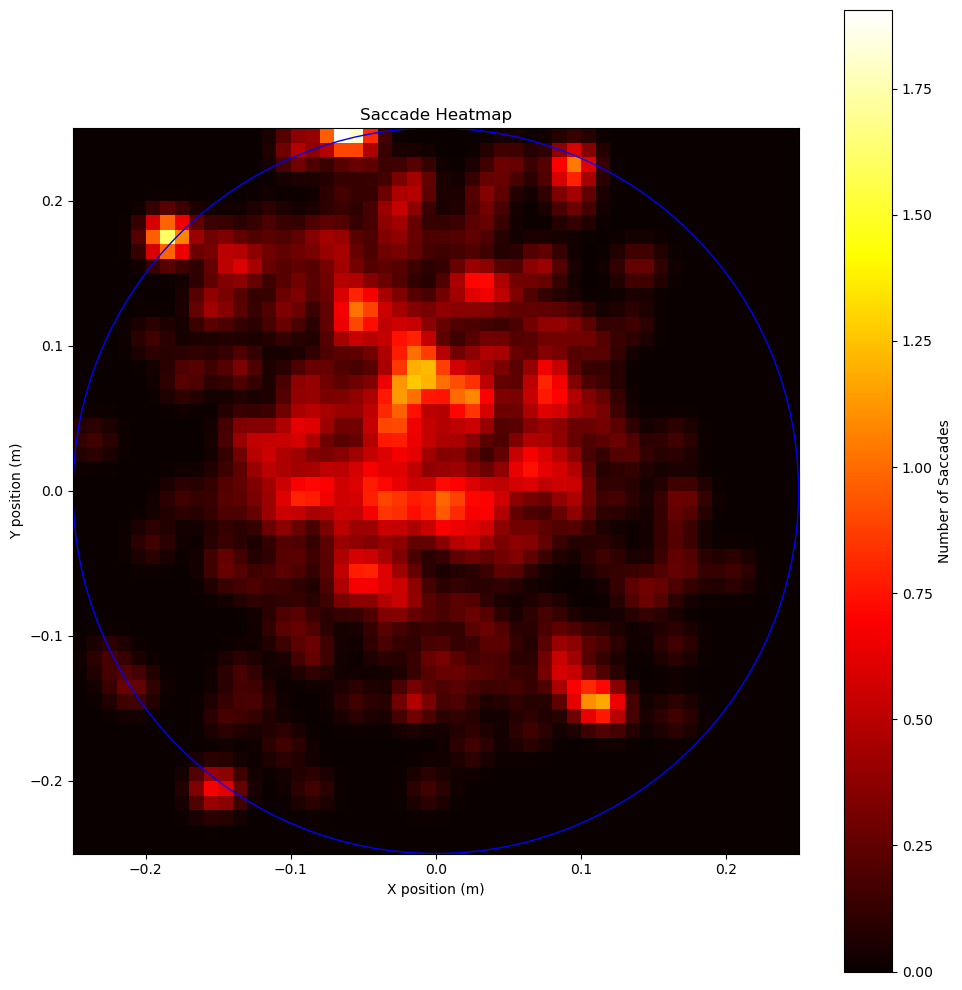

In [28]:
plt.close('all')
heatmap = create_saccade_heatmap(df)
plot_saccade_heatmap(heatmap, sigma=1)